In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyBboxPatch
from matplotlib.colors import LinearSegmentedColormap
from layouts import keyboard_layouts

# Set colors
KEYBOARD_BG_COLOR = "#1c1c1c"
KEY_FONT = "DejaVu Sans Mono"
DEFAULT_KEY_COLOR = "#656363"


# class to store keys
class Key:
    def __init__(
        self, ind, char, x, y, width, height, side, start, shift_char=None, freq=0
    ):
        self.ind = ind
        self.char = char
        self.shift_char = shift_char
        self.freq = freq
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.travel = 0
        self.start = start
        self.side = side


# The keyboard class
class Keyboard:
    def __init__(self, s):
        # select layout
        self.listed_keyboard_layout = keyboard_layouts[s.lower()]
        self.total_travel = 0

        self.store_layout()
        self.calc_travel()
        self.display_keys()

    # store the layout as a list of keys
    def store_layout(self):
        self.key_index = {}
        self.keyboard_layout = []

        index = 0

        x_start = 100.0
        y_start = -100.0
        x_end = -100.0
        y_end = +100.0

        for key in self.listed_keyboard_layout:
            # set properties
            chars = key["chars"]
            (x, y) = key["position"]
            (w, h) = key["dimensions"]
            start = key["start"]
            normal_char = chars[0]
            side = key["side"]

            if len(chars) > 1:
                shift_char = chars[1]
                self.key_index[shift_char] = index
            else:
                shift_char = None

            # append to list
            keyobj = Key(
                index,
                normal_char,
                shift_char=shift_char,
                x=x,
                y=y,
                width=w,
                height=h,
                start=start,
                side=side,
            )
            self.keyboard_layout.append(keyobj)
            self.key_index[normal_char] = index  # map characters to keys

            index += 1

            x_start = min(x_start, x)
            y_start = max(y_start, y + h)
            x_end = max(x_end, x + w)
            y_end = min(y_end, y)

        # dimensions of the keyboard
        self.x_start = x_start
        self.y_start = y_start
        self.x_end = x_end
        self.y_end = y_end

        # map space and new line keys
        self.key_index[" "] = self.key_index["SPACE"]
        self.key_index["\n"] = self.key_index["ENTER"]

    # calculate and store the travel of each keys
    # removes the necesity to calculate distance everytime
    def calc_travel(self):
        for key in self.keyboard_layout:
            x1, y1 = key.x + key.width / 2, key.y + key.height / 2
            start_key = self.keyboard_layout[self.key_index[key.start]]
            x2, y2 = (
                start_key.x + start_key.width / 2,
                start_key.y + start_key.height / 2,
            )
            key.travel = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    # display the keys as rectangles
    def display_keys(self):
        # define plot
        self.fig, self.ax = plt.subplots(
            figsize=(
                (self.x_end - self.x_start) * 12 / 16,
                (self.y_start - self.y_end) * 8 / 6.5,
            )
        )
        self.fig.patch.set_facecolor(KEYBOARD_BG_COLOR)

        # store the key pieces in a list
        self.rectangles = []

        # display the keys
        for key_obj in self.keyboard_layout:
            key_color = DEFAULT_KEY_COLOR
            x_pos, y_pos, width, height = (
                key_obj.x,
                key_obj.y,
                key_obj.width,
                key_obj.height,
            )

            # rectangle with curved corners
            rect = FancyBboxPatch(
                (x_pos, y_pos),
                width,
                height,
                edgecolor="black",
                facecolor=key_color,
                boxstyle="round,pad=0.0,rounding_size=0.1",
            )

            self.rectangles.append(rect)
            self.ax.add_patch(rect)

            key = key_obj.char
            freq = key_obj.freq

            # display text and shift text
            label = key.upper()
            self.ax.text(
                x_pos + width / 2,
                y_pos + height / 2,
                label,
                ha="center",
                va="center",
                fontsize=10,
                font=KEY_FONT,
                zorder=100,
            )

            shift_key = key_obj.shift_char

            if shift_key != None and not shift_key.isalpha():
                self.ax.text(
                    x_pos + width / 5,
                    y_pos + 0.75,
                    shift_key.upper(),
                    ha="center",
                    va="center",
                    fontsize=10,
                    font=KEY_FONT,
                    zorder=100,
                )

        # display keyboard
        self.ax.set_xlim(self.x_start, self.x_end)
        self.ax.set_ylim(self.y_end, self.y_start)
        self.ax.set_aspect("equal")
        self.ax.axis("off")
        # plt.draw()
        # plt.pause(0.01)
        self.clrmsk = 0

    # creates radial color mask at given position and of given radius
    def create_radial_gradient(self, grayscale, xcentre, ycentre, xradius, yradius):
        mid = grayscale * 0.8

        # Calculate coordinates and radii in normalized units
        x0 = int(self.xRES * (xcentre - self.x_start) / (self.x_end - self.x_start))
        y0 = int(self.yRES * (ycentre - self.y_start) / (self.y_end - self.y_start))
        rx = abs(int(self.xRES * xradius / (self.x_end - self.x_start)))
        ry = abs(int(self.yRES * yradius / (self.y_end - self.y_start)))

        # define the range of the gradient
        fact = 3
        xmin = max(0, x0 - fact * rx)
        xmax = min(self.xRES, x0 + fact * rx)
        ymin = max(0, y0 - fact * ry)
        ymax = min(self.yRES, y0 + fact * ry)

        # Create meshgrid of x and y coordinates
        x = np.arange(xmin, xmax)
        y = np.arange(ymin, ymax)
        xx, yy = np.meshgrid(x, y)

        # Calculate distances from the center
        r = np.sqrt((xx - x0) ** 2 + (yy - y0) ** 2)

        # Calculate grayscale and alpha values with gaussian distribution
        val = mid * np.exp(-(r**2) * 0.0005)
        alpha = mid * np.exp(-(r**2) * 0.0004)

        # Add to prexisting values
        self.grey_mask[-yy - 1, xx] = np.minimum(0.9, val + self.grey_mask[-yy - 1, xx])
        self.alpha_mask[-yy - 1, xx] = np.minimum(
            0.8, alpha + self.alpha_mask[-yy - 1, xx]
        )

    # generate color map from
    def colorize(self):
        colored = self.cmap(self.grey_mask)
        colored[..., 3] = self.alpha_mask
        self.color_mask = colored

    # function to draw heat map on the keyboard
    def draw_keyboard_layout(self):
        # set resolution of heatmap
        self.xRES = 1000
        self.yRES = abs(
            int(self.xRES * (self.y_end - self.y_start) / (self.x_end - self.x_start))
        )

        # initialise numpy arrays
        self.color_mask = np.zeros((self.yRES, self.xRES, 4))
        self.grey_mask = np.zeros((self.yRES, self.xRES))
        self.alpha_mask = np.zeros((self.yRES, self.xRES))

        # clear heat map
        if self.clrmsk:
            self.clrmsk.remove()

        for key_obj in self.keyboard_layout:
            freq = key_obj.freq
            x_pos, y_pos, width, height = (
                key_obj.x,
                key_obj.y,
                key_obj.width,
                key_obj.height,
            )

            if freq and self.THRESH:
                # define offset of heatmap around the key
                offset = 0.6
                # create the gradient on the heatmap array
                self.create_radial_gradient(
                    grayscale=(freq / self.THRESH),
                    xcentre=x_pos + width / 2,
                    ycentre=y_pos + height / 2,
                    xradius=width / 2 + offset,
                    yradius=height / 2 + offset,
                )

        # colorize the grayscale array
        self.colorize()

        # show the heatmap over the keys
        self.clrmsk = self.ax.imshow(
            self.color_mask,
            extent=(self.x_start, self.x_end, self.y_end, self.y_start),
            origin="lower",
            zorder=5,
        )
        self.ax.set_xlim(self.x_start, self.x_end)
        self.ax.set_ylim(self.y_end, self.y_start)
        self.ax.set_aspect("equal")
        self.ax.axis("off")

    # function to reset heatmap
    def clear_keyboard(self):
        for key in self.keyboard_layout:
            key.freq = 0
        self.THRESH = 0
        print("cleared")

    # run with or without input string and with our without type animation
    def run(self, s="", animate=False, live_input=True):
        self.cmap = plt.cm.jet
        i = 0
        self.THRESH = 0  # initialize max freq to 0

        while True:
            while i < len(s):
                if s[i] not in self.key_index:  # ignore unusual characters
                    i += 1
                    continue

                # access corresponding key
                ind = self.key_index[s[i]]
                key = self.keyboard_layout[ind]

                self.total_travel += key.travel  # update travel distance

                if s[i] == " ":  # ignores space key for better visualisation
                    i += 1
                    continue

                # increase frequency and update max frequency
                key.freq += 1
                self.THRESH = max(self.THRESH, key.freq)

                # find the corresponding shift key
                shift = "R" if key.side == "L" else "L"
                shift_rect = self.rectangles[self.key_index[shift + "SHIFT"]]

                # increase shift's freq if necessary
                if key.shift_char == s[i]:
                    shift = "R" if key.side == "L" else "L"
                    self.keyboard_layout[self.key_index[shift + "SHIFT"]].freq += 1
                    self.THRESH = max(
                        self.THRESH,
                        self.keyboard_layout[self.key_index[key.side + "SHIFT"]].freq,
                    )

                # increase the size of current key for a small period of time
                if animate:
                    xpos, ypos, w, h = key.x, key.y, key.width, key.height
                    rect = self.rectangles[ind]

                    scale = 1.3
                    rect.set_zorder(11)
                    rect.set_alpha(0.5)
                    rect.set_bounds(
                        xpos + w / 2 - w * scale / 2,
                        ypos + h / 2 - h * scale / 2,
                        w * scale,
                        h * scale,
                    )

                    self.draw_keyboard_layout()
                    plt.draw()

                    plt.pause(0.4)

                    # reset
                    rect.set_zorder(1)
                    rect.set_alpha(1)
                    rect.set_bounds(xpos, ypos, w, h)

                i += 1

            # print travel distance
            print("Total finger travel distance : ", round(self.total_travel,2), "units")

            # dray heatmap
            self.draw_keyboard_layout()

            # display heat map and exit
            if not live_input:
                plt.show()
                break
                
            plt.draw()
            plt.pause(0.01)

            # take input from user
            t = input()

            # end program if quit is entered
            if t.lower().strip() == "quit":
                break

            # reset keyboard if clear is entered
            if t.lower().strip() == "clear":
                self.clear_keyboard()
                self.THRESH = 0
                s = ""
                t = ""
                i = 0
                self.total_travel = 0
            s += t  # append t

        # print final string
        # print(s)

In [9]:
# Sample Text
s = '''
arrangement of the legends (labels, markings, engravings) that appear on those keys. Functional layout is the arrangement of the key-meaning association or keyboard mapping, determined in software, of all the keys of a keyboard; it is this (rather than the legends) that determines the actual response to a key press.

Modern computer keyboards are designed to send a scancode to the operating system (OS) when a key is pressed or released. This code reports only the key's row and column, not the specific character engraved on that key. The OS converts the scancode into a specific binary character code using a "scancode to character" conversion table, called the keyboard mapping table. This means that a physical keyboard may be dynamically mapped to any layout without switching hardware components—merely by changing the software that interprets the keystrokes. Often,[a] a user can change keyboard mapping in system settings. In addition, software may be available to modify or extend keyboard functionality.[b] Thus the symbol shown on the physical key-top need not be the same as appears on the screen or goes into a document being typed. Modern USB keyboards are plug-and-play; they communicate their (default) visual layout to the OS when connected (though the user is still able to reset this at will).

Key types

A typical 105-key computer keyboard, consisting of sections with different types of keys
A computer keyboard consists of alphanumeric or character keys for typing, modifier keys for altering the functions of other keys,[1] navigation keys for moving the text cursor on the screen, function keys and system command keys—such as Esc and Break—for special actions, and often a numeric keypad to facilitate calculations.[2][3]

There is some variation between different keyboard models in the physical layout—i.e., how many keys there are and how they are positioned on the keyboard.[4] However, differences between national layouts are mostly due to different selections and placements of symbols on the character keys.[5]

Character keys
The core section of a keyboard consists of character keys, which can be used to type letters and other characters. Typically, there are three rows of keys for typing letters and punctuation, an upper row for typing digits and special symbols, and the Space bar on the bottom row. The positioning of the character keys is similar to the keyboard of a typewriter.

Modifier keys
Main article: Modifier key

MIT "space-cadet" keyboard, a pre-ISO/IEC 9995 keyboard with a large number of modifier keys. It was equipped with four keys for bucky bits (Control, Meta, Hyper, and Super); and three shift keys, called "shift", "top", and "front".
Besides the character keys, a keyboard incorporates special keys that do nothing by themselves but modify the functions of other keys. For example, the ⇧ Shift key can be used to alter the output of character keys, whereas the Ctrl (control), Alt (alternate) and AltGr (alternative graphic) keys trigger special operations when used in concert with other keys. (Apple keyboards have differently labelled but equivalent keys, see below).

Typically, a modifier key is held down while another key is struck. To facilitate this, modifier keys usually come in pairs, one functionally identical key for each hand, so holding a modifier key with one hand leaves the other hand free to strike another key.

An alphanumeric key labelled with only a single letter (usually the capital form) can generally be struck to type either a lower case or capital letter, the latter requiring the simultaneous holding of the ⇧ Shift key. The ⇧ Shift key is also used to type the upper of two symbols engraved on a given key, the lower being typed without using the modifier key.

The Latin alphabet keyboard has a dedicated key for each of the letters A–Z, keys for punctuation and other symbols, usually a row of function keys, often a numeric keypad and some system control keys. In most languages except English, additional letters (some with diacritics) are required and some are present as standard on each national keyboard, as appropriate for its national language. These keyboards have another modified key, labelled AltGr (alternative graphic), to the right of the space bar. (US keyboards just have a second Alt key in this position). It can be used to type an extra symbol in addition to the two otherwise available with an alphanumeric key, and using it simultaneously with the ⇧ Shift key usually gives access to a fourth symbol. These third-level and fourth-level symbols may be engraved on the right half of the key top, or they may be unmarked. Cyrillic alphabet and Greek alphabet keyboards have similar arrangements.

Instead of the Ctrl, Alt and AltGr keys seen on commodity keyboards, Apple Keyboards have ⌘ Cmd (command) and ⌥ Option keys. The ⌥ Option key is used much like the AltGr, and the ⌘ Cmd key like the Ctrl and Alt, to access menu options and shortcuts. Macs have a Ctrl key for compatibility with programs that expect a more traditional keyboard layout. It is especially useful when using a terminal, X11 (a Unix environment included with OS X as an install option) or MS Windows. The key can generally be used to produce a secondary mouse click as well. There is also a Fn key on modern Mac keyboards, which is used for switching between use of the F1, F2, etc. keys either as function keys or for other functions like media control, accessing Spotlight, controlling the volume, or handling Mission Control. Fn key can be also found on smaller Windows and Linux laptops and tablets, where it serves a similar purpose.

Many Unix workstations (and also home computers like the Amiga) keyboards placed the Ctrl key to the left of the letter A, and the ⇪ Caps Lock key in the bottom left. This position of the Ctrl key is also used on the XO laptop, which does not have a ⇪ Caps Lock. The UNIX keyboard layout also differs in the placement of the Esc key, which is to the left of 1.

Some early keyboards experimented with using large numbers of modifier keys. The most extreme example of such a keyboard, the so-called "space-cadet keyboard" found on MIT LISP machines, had no fewer than seven modifier keys: four control keys, Ctrl, Meta, Hyper, and Super, along with three shift keys, ⇧ Shift, Top, and Front. This allowed the user to type over 8000 possible characters by playing suitable "chords" with many modifier keys pressed simultaneously.

Dead keys
Main article: Dead key
A dead key is a special kind of a modifier key that, instead of being held while another key is struck, is pressed and released before the other key. The dead key does not generate a character by itself, but it modifies the character generated by the key struck immediately after, typically making it possible to type a letter with a specific diacritic. For example, on some keyboard layouts, the grave accent key ` is a dead key: in this case, striking ` and then A results in à (a with grave accent); ` followed by ⇧ Shift+E results in È (E with grave accent). A grave accent in isolated form can be typed by striking ` and then Space bar.

A key may function as a dead key by default, or sometimes a normal key can temporarily be altered to function as a dead key by simultaneously holding down the secondary-shift key—AltGr or ⌥ Option: a typical example might be AltGr+6 a will produce â (assuming the "6" key is also the "^" key). In some systems, there is no indication to the user that a dead key has been struck, so the key appears dead, but in some text-entry systems the diacritical mark is displayed along with an indication that the system is waiting for another keystroke: either the base character to be marked, an additional diacritical mark, or Space bar to produce the diacritical mark in isolation.

Compared with the secondary-shift modifier key, the dead-key approach may be a little more complicated, but it allows more additional letters. Using AltGr, only one or (if used simultaneously with the normal shift key) two additional letters with each key, whereas using a dead key, a specific diacritic can be attached to a range of different base letters.

Compose key
Main article: Compose key
A Compose key can be characterized as a generic dead key that may in some systems be available instead of or in addition to the more specific dead keys. It allows access to a wide range of predefined extra characters by interpreting a whole sequence of keystrokes following it. For example, striking Compose followed by ' (apostrophe) and then A results in á (a with acute accent), Compose followed by A and then E results in æ (ae ligature), and Compose followed by O and then C results in © (circled c, copyright symbol).

The Compose key is supported by the X Window System (used by most Unix-like operating systems, including most Linux distributions). Some keyboards have a key labeled "Compose", but any key can be configured to serve this function. For example, the otherwise redundant right-hand ⊞ Win key may, when available, be used for this purpose. This can be emulated in Windows with third party programs, for example WinCompose.

System command keys
Depending on the application, some keyboard keys are not used to enter a printable character but instead are interpreted by the system as a formatting, mode shift, or special commands to the system. The following examples are found on personal computer keyboards.

SysRq and PrtSc

4800-52 mainframe / dumb terminal keyboard, c. mid-1980s. There is an obscure configuration of modifier and arrow keys, line feed key, break key, blank keys, and repeat key.
The system request (SysRq) and print screen (PrtSc or on some keyboards e.g. PrtScn) commands often share the same key. SysRq was used in earlier computers as a "panic" button to recover from crashes (and it is still used in this sense to some extent by the Linux kernel; see Magic SysRq key). The print screen command is used to capture the entire screen and send it to the printer, but in the present, it usually puts a screenshot in the clipboard.

Break key
The Break key/Pause key no longer has a well-defined purpose. Its origins go back to teleprinter users, who wanted a key that would temporarily interrupt the communications line. The Break key can be used by software in several different ways, such as to switch between multiple login sessions, to terminate a program, or to interrupt a modem connection.

In programming, especially old DOS-style BASIC, Pascal and C, Break is used (in conjunction with Ctrl) to stop program execution. In addition to this, Linux and variants, as well as many DOS programs, treat this combination the same as Ctrl+C. On modern keyboards, the break key is usually labeled Pause/Break. In most Microsoft Windows environments, the key combination WindowsPause brings up the system properties.

Escape key
Main article: Esc key
The escape key (often abbreviated Esc) "nearly all of the time"[6] signals Stop,[7] QUIT,[8] or let me "get out of a dialog"[6] (or pop-up window).[9]

Another common application today of the Esc key is to trigger the Stop button in many web browsers and operating systems.[6]

ESC was part of the standard keyboard of the Teletype Model 33 (introduced in 1964 and used with many early minicomputers).[10] The DEC VT50, introduced July 1974, also had an Esc key. The TECO text editor (c. 1963) and its descendant Emacs (c. 1985) use the Esc key extensively.

Historically it also served as a type of shift key, such that one or more following characters were interpreted differently, hence the term escape sequence, which refers to a series of characters, usually preceded by the escape character.[11][12]

On machines running Microsoft Windows, prior to the implementation of the Windows key on keyboards, the typical practice for invoking the "start" button was to hold down the control key and press escape. This process still works in Windows 10 and 11.[13]

Enter key
An "enter" key may terminate a paragraph of text and advance an editing cursor to the start of the next available line, similar to the "carriage return" key of a typewriter. When the attached system is processing a user command line, pressing "enter" may signal that the command has been completely entered and that the system may now process it.

Shift key
Shift key: when one presses shift and a letter, it will capitalize the letter pressed with the shift key. Another use is to type more symbols than appear to be available, for instance the semi-colon key is accompanied with a colon symbol on the top. To type a semi-colon, the key is pressed without pressing any other key. To type a colon, both this key and the Shift key are pressed concurrently. (Some systems make provision for users with mobility impairment by allowing the Shift key to be pressed first and then the desired symbol key).

Menu key, Command key, Windows key
The Menu key or Application key is a key found on Windows-oriented computer keyboards: on Apple keyboard the same function is provided by the Command key (labelled ⌘). It is used to launch a context menu with the keyboard rather than with the usual right mouse button. The key's symbol is usually a small icon depicting a cursor hovering above a menu. On some Samsung keyboards the cursor in the icon is not present, showing the menu only. This key was created at the same time as the Windows key. This key is normally used when the right mouse button is not present on the mouse. Some Windows public terminals do not have a Menu key on their keyboard to prevent users from right-clicking (however, in many Windows applications, a similar functionality can be invoked with the Shift+F10 keyboard shortcut).

The Windows key opens the 'Start' (applications) menu.

History
Main article: Typewriter

Keyboard of a Letter-Printing Telegraph Set built by Siemens and Halske in Russia c. 1900
Keyboard layouts have evolved over time, usually alongside major technology changes. Particularly influential have been: the Sholes and Glidden typewriter (1874, also known as Remington No. 1), the first commercially successful typewriter, which introduced QWERTY;[14] its successor, the Remington No. 2 (1878), which introduced the shift key; the IBM Selectric (1961), a very influential electric typewriter, which was imitated by computer keyboards;[15] and the IBM PC (1981), namely the Model M (1985), which is the basis for many modern keyboard layouts.

Within a community, keyboard layout is generally quite stable, due to the high training cost of touch-typing, and the resulting network effect of having a standard layout and high switching cost of retraining, and the ubiquity of the QWERTY layout is a case study in switching costs. Nevertheless, significant market forces can result in changes (as in Turkish adoption of QWERTY), and non-core keys are more prone to change, as they are less frequently used and less subject to the lock-in of touch-typing. The main, alphanumeric portion is typically stable, while symbol keys and shifted key values change somewhat, modifier keys more so, and function keys most of all: QWERTY dates to the No. 1 (1874)—though 1 and 0 were added later—shifted keys date in some cases to the No. 2 (1878), in other cases to the Selectric (1961), and modifier key placement largely dates to the Model M (1985); function key placement typically dates to the Model M, but varies significantly, particularly on laptops.

The earliest mechanical keyboards were used in musical instruments to play particular notes. With the advent of the printing telegraph, a keyboard was needed to select characters. Some of the earliest printing telegraph machines either used a piano keyboard outright or a layout similar to a piano keyboard.[16][17] The Hughes-Phelps printing telegraph piano keyboard laid keys A-N in left-to-right order on the black piano keys, and keys O-Z in right-to-left order on the white piano keys below.

In countries using the Latin script, the center, alphanumeric portion of the modern keyboard is most often based on the QWERTY design by Christopher Sholes. Sholes' layout was long thought to have been laid out in such a way that common two-letter combinations were placed on opposite sides of the keyboard so that his mechanical keyboard would not jam. However, evidence for this claim has often been contested. In 2012, an argument was advanced by two Japanese historians of technology showing that the key order on the earliest Sholes prototypes in fact followed the left-right and right-left arrangement of the contemporary Hughes-Phelps printing telegraph, described above.[18] Later iterations diverged progressively for various technical reasons, and strong vestiges of the left-right A-N, right-left O-Z arrangement can still be seen in the modern QWERTY layout. Sholes' chief improvement was thus to lay out the keys in rows offset horizontally from each other by three-eighths, three-sixteenths, and three-eighths inches to provide room for the levers and to reduce hand-movement distance. Although it has been demonstrated that the QWERTY layout is not the most efficient layout for typing,[19] it remains the standard.

Sholes chose the size of the keys to be on three-quarter [3⁄4, or 0.75] inch centers (about 19 mm, versus musical piano keys which are 23.5 mm or about 0.93 inches wide). 0.75 inches has turned out to be optimum for fast key entry by the average-size hand, and keyboards with this key size are called "full-sized keyboards".

On a manual typewriter, the operator could press the key down with a lighter touch for such characters as the period or comma, which did not occupy as much area on the paper. Since an electric typewriter supplied the force to the typebar itself after the typist merely touched the key, the typewriter itself had to be designed to supply different forces for different characters. To simplify this, the most common layout for electric typewriters in the United States differed from that for the one most common on manual typewriters. Single-quote and double-quote, instead of being above the keys for the digits 2 and 8 respectively, were placed together on a key of their own. The underscore, another light character, replaced the asterisk above the hyphen.

The ASCII communications code was designed so that characters on a mechanical teletypewriter keyboard could be laid out in a manner somewhat resembling that of a manual typewriter. This was imperfect, as some shifted special characters were moved one key to the left, as the number zero, although on the right, was low in code sequence. Later, when computer terminals were designed from less expensive electronic components, it was not necessary to have any bits in common between the shifted and unshifted characters on a given key. This eventually led to standards being adopted for the "bit-pairing" and "typewriter-pairing" forms of keyboards for computer terminals.

The typewriter-pairing standard came under reconsideration, on the basis that typewriters have many different keyboard arrangements.[20] The U.S. keyboard for the IBM PC, although it resembles the typewriter-pairing standard in most respects, differs in one significant respect: the braces are on the same two keys as the brackets, as their shifts. This innovation predated the IBM Personal Computer by several years.[21]

IBM adopted the 101/102 key layout on the PS/2 in 1987 (after previously using an 84-key keyboard that did not have a separate cursor and numeric keypads).

Most modern keyboards basically conform to the layout specifications contained in parts 1, 2, and 5 of the international standard series ISO/IEC 9995. These specifications were first defined by the user group at AFNOR in 1984 working under the direction of Alain Souloumiac.[22] Based on this work, a well-known ergonomic expert wrote a report[23] which was adopted at the ISO Berlin meeting in 1985 and became the reference for keyboard layouts.

The 104/105-key PC keyboard was born when two ⊞ Win keys and a ≣ Menu key were added on the bottom row (originally for the Microsoft Windows operating system). Newer keyboards may incorporate even further additions, such as Internet access (World Wide Web navigation) keys and multimedia (access to media players) buttons.

Physical, visual, and functional layouts
As noted before, the layout of a keyboard may refer to its physical (arrangement of keys), visual (physical labeling of keys), or functional (software response to a key press or release) layout.

Physical layouts

A comparison of common physical layouts. The ISO-standard physical layout (center left) is common, e.g., in the United Kingdom. Compared with the ANSI layout (top left), the enter key is vertical rather than horizontal. In addition, the left shift key is smaller, to make room for an additional key to its right. The JIS physical layout (bottom right) is the basis for Japanese keyboards. Here it is the right-hand shift key that is smaller. Furthermore, the space bar and backspace key are also smaller, to make room for four additional keys.
Physical layouts only address tangible differences among keyboards. When a key is pressed, the keyboard does not send a message such as the A-key is depressed but rather the left-most main key of the home row is depressed. (Technically, each key has an internal reference number, the scan code, and these numbers are what is sent to the computer when a key is pressed or released.) The keyboard and the computer each have no information about what is marked on that key, and it could equally well be the letter A or the digit 9. Historically, the user of the computer was requested to identify the functional layout of the keyboard when installing or customizing the operating system. Modern USB keyboards are plug-and-play; they communicate their visual layout to the OS when connected (though the user is still able to reset this at will).[example needed]

Today, most keyboards use one of three different physical layouts, usually referred to as simply ISO (ISO/IEC 9995-2), ANSI (ANSI-INCITS 154-1988), and JIS (JIS X 6002-1980), referring roughly to the organizations issuing the relevant worldwide, United States, and Japanese standards, respectively. (In fact, the physical layouts referred such as "ISO" and "ANSI" comply with the primary recommendations in the named standards, while each of these standards in fact also allows the other.) Keyboard layout in this sense may refer either to this broad categorization or to finer distinctions within these categories. For example, as of May 2008, Apple Inc. produces ISO, ANSI, and JIS desktop keyboards, each in both extended and compact forms. The extended keyboards have 110, 109, and 112 keys (ISO, ANSI, and JIS, respectively), and the compact models have 79, 78, and 80.

Visual layouts

A visual layout consisting of both factory-printed symbols and customized stickers
The visual layout includes the symbols printed on the physical keycaps. Visual layouts vary by language, country, and user preference, and any one physical and functional layout can be employed with a number of different visual layouts. For example, the "ISO" keyboard layout is used throughout Europe, but typical French, German, and UK variants of physically identical keyboards appear different because they bear different legends on their keys. Even blank keyboards—with no legends—are sometimes used to learn typing skills or by user preference.

Some users choose to attach custom labels on top of their keycaps. This can be, e.g., for masking foreign layouts, adding additional information such as shortcuts, learning aids, gaming controls, or solely for decorational purposes.

Functional layouts
The functional layout of the keyboard refers to the mapping between the physical keys, such as the A key, and software events, such as the letter "A" appearing on the screen. Usually the functional layout is set (in the system configuration) to match the visual layout of the keyboard being used, so that pressing a key will produce the expected result, corresponding to the legends on the keyboard. However, most operating systems have software that allow the user to easily switch between functional layouts, such as the language bar in Microsoft Windows. For example, a user with a Swedish keyboard who wishes to type more easily in German may switch to a functional layout intended for German—without regard to key markings—just as a Dvorak touch typist may choose a Dvorak layout regardless of the visual layout of the keyboard used.

Customized functional layouts
See also: Overlay keyboard
Functional layouts can be redefined or customized within the operating system, by reconfiguring the operating system keyboard driver, or with the use of a separate software application. Transliteration is one example of that whereby letters in other languages get matched to visible Latin letters on the keyboard by the way they sound. Thus, a touch typist can type in various foreign languages with a visible English-language keyboard only.

Mixed hardware-to-software keyboard extensions exist to overcome the above discrepancies between functional and visual layouts. A keyboard overlay[24] is a plastic or paper masks that can be placed over the empty space between the keys, providing the user with the functional use of various keys. Alternatively, a user applies keyboard stickers with an extra imprinted language alphabet and adds another keyboard layout via language support options in the operating system.[25] The visual layout of any keyboard can also be changed by simply replacing its keys or attaching labels to them, such as to change an English-language keyboard from the common QWERTY to the Dvorak layout, although for touch typists, the placement of the tactile bumps on the home keys is of more practical importance than that of the visual markings.

In the past, complex software that mapped many non-standard functions to the keys (such as a flight simulator) would be shipped with a "keyboard overlay", a large sheet of paper with pre-cut holes matching the key layout of a particular model of computer. When placed over the keyboard, the overlay provided a quick visual reference as to what each key's new function was, without blocking the keys or permanently modifying their appearance. The overlay was often made from good-quality laminated paper and was designed to fold up and fit in the game's packaging when not in use.

National variants
The U.S. IBM PC keyboard has 104 keys, while the PC keyboards for most other countries have 105 keys. In an operating system configured for a non-English language, the keys are placed differently. For example, keyboards designed for typing in Spanish have some characters shifted, to make room for Ñ/ñ; similarly those for French or Portuguese may have a special key for the character Ç/ç. Keyboards designed for Japanese may have special keys to switch between Japanese and Latin scripts, and the character ¥ (yen and yuan sign) instead of \ (backslash – which itself additionally may be displayed as a ¥ or a ₩ in some renditions). Using the same keyboard for alternative languages leads to a conflict: the image on the key may not correspond to the character displayed on screen because of different keyboard mappings. In such cases, each new language may require an additional label on the key, because the national standard keyboard layouts may not share similar characters of different languages or even lay them out in different ways.

The United States keyboard layout is used as default in some Linux distributions.[26]

Most operating systems allow switching between functional keyboard layouts, using a key combination involving register keys that are not used for normal operations (e.g. Microsoft reserve Alt+⇧ Shift or Ctrl+⇧ Shift register control keys for sequential layout switching; those keys were inherited from old DOS keyboard drivers). There are keyboards with two parallel sets of characters labeled on the keys, representing alternate alphabets or scripts. It is also possible to add a second set of characters to a keyboard with keyboard stickers manufactured by third parties.

Size variation
Further information: Computer keyboard § Types and standards

Sections on a standard 104 keyboard. Percentages and relevant values of keys denote the presence of keys at common keyboard sizes.
Modern keyboard models contain a set number of total keys according to their given standard, described as 104, 105, etc., and sold as "full-size" keyboards.[27] This number is not always followed, and individual keys or whole sections are commonly skipped for the sake of compactness or user preference. Consequently, generic keyboard mappings may not be completely effective on unusual layouts.
'''

Total finger travel distance :  22779.86 units


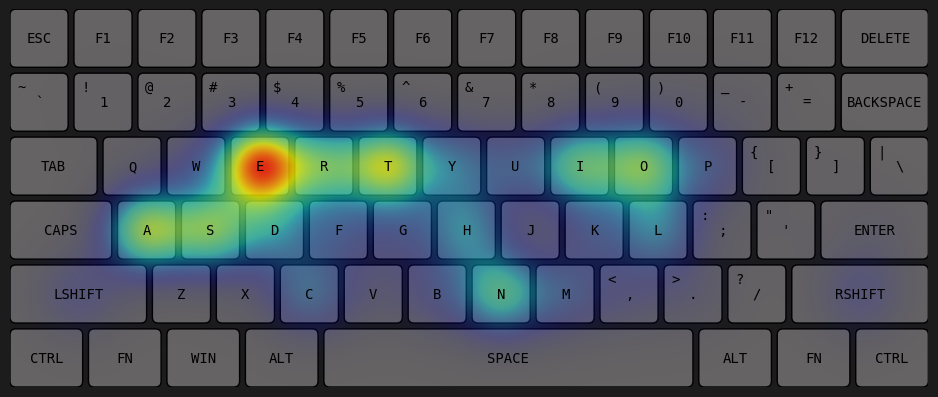

In [10]:
keyboard = Keyboard('qwerty')
keyboard.run(s, animate=False, live_input=False) 

Total finger travel distance :  14848.64 units


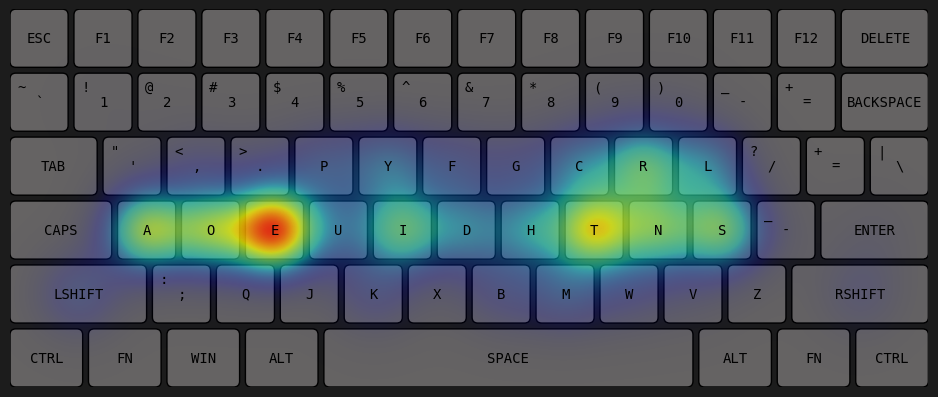

In [12]:
keyboard = Keyboard('dvorak')
keyboard.run(s, animate=False, live_input=False) 

Total finger travel distance :  12782.07 units


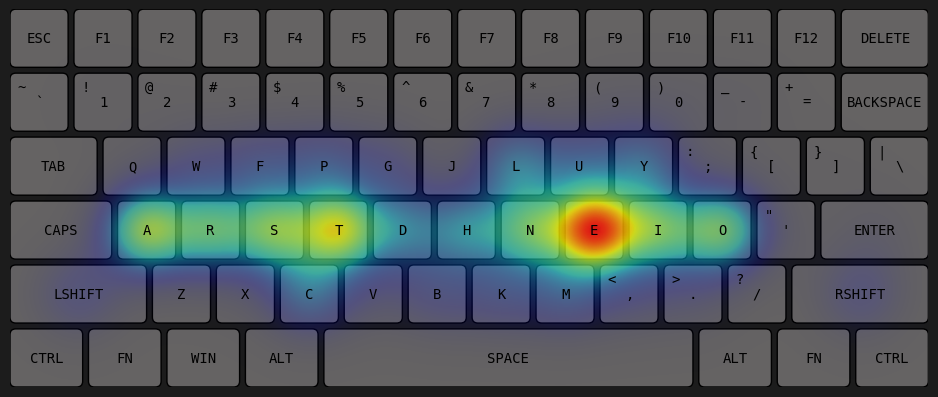

In [13]:
keyboard = Keyboard('colemak')
keyboard.run(s, animate=False, live_input=False) 

Total finger travel distance :  23710.88 units


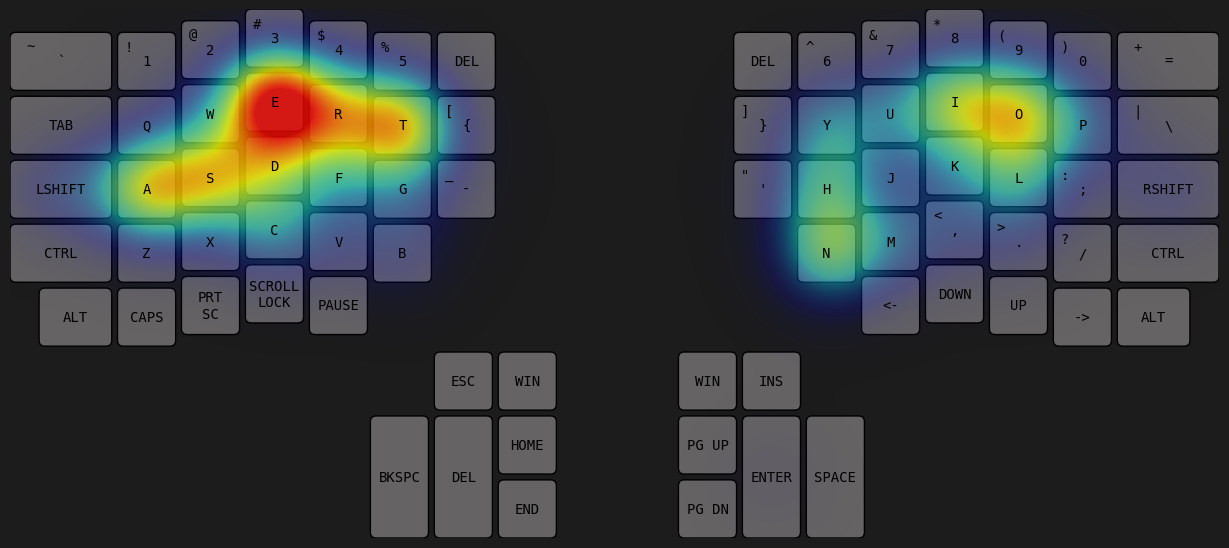

In [11]:
keyboard = Keyboard('ergodox')
keyboard.run(s, animate=False, live_input=False) 